# Supercontinuum with the generalized nonlinear Schrodinger equation

In [1]:
cd ../../src/NonlinearOptics/

/home/fpresutti/src/NonlinearOptics


In [2]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift

from nonlinearmedium import Chi3GNLSE

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib notebook
plt.rcParams["figure.figsize"] = [9, 6]

Propagate a 50 fs pulse through a silica fiber with anomalous disperson.

In [4]:
c = 299792458 # m / s

pumpWav  = 835 # nm
pumpFreq = 2e-3 * np.pi * c / pumpWav # 2pi THz

# Bandwidth limited pulse time scale
timeScale = 50e-3 # ps

In [5]:
# nt works best as multiples of 2, 3 and 5
nt = 2**11
tMax = 70

# normalized
tau   = (2 * tMax / nt) * ifftshift(np.arange(-nt / 2, nt / 2))
omega = (-np.pi / tMax) *  fftshift(np.arange(-nt / 2, nt / 2))

wMax = np.max(omega)
angFreqMax = wMax / timeScale
freqMax = angFreqMax / (2 * np.pi)

# dimensionful
time    = tau * timeScale   # ps
angFreq = omega / timeScale # 2 pi THz
wavelengthP = 2e-3 * np.pi * c / (angFreq + pumpFreq) # nm

In [6]:
fiber = Chi3GNLSE(
            relativeLength = 1,
            nlLength = 1/5**2,
            selfSteepLength = 1/5**2 * (pumpFreq * timeScale),
            beta2 = -1,
            beta3 = 5e-2 * 6,

            fr = 0.245,
            fb = 0.21,
            tau1 = 12.2e-3 / timeScale,
            tau2 = 32e-3 / timeScale,
            tau3 = 96e-3 / timeScale,

            tPrecision=nt, tMax=tMax, zPrecision=100)

In [7]:
# Hyperbolic secant pulse
fiber.runSignalSimulation(1 / np.cosh(tau + 1.75 / timeScale), inTimeDomain=True)

<IPython.core.display.Javascript object>


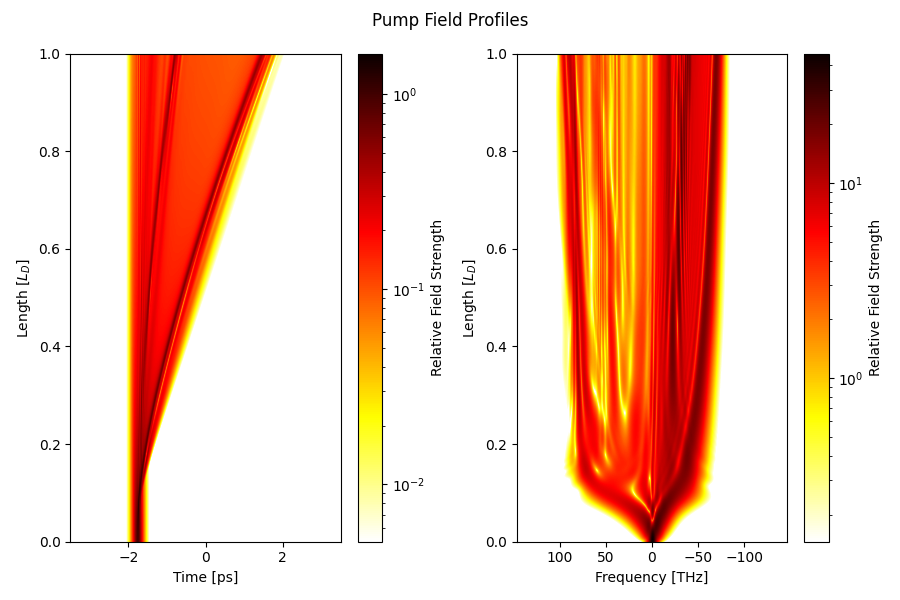

In [8]:
fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
maxField = np.abs(fiber.signalTime).max()
plt.imshow(np.abs(fftshift(fiber.signalTime, axes=1)), aspect="auto", origin="lower", cmap="hot_r",
           extent=[-tMax * timeScale, tMax * timeScale, 0, 1],
           norm=LogNorm(vmin=maxField * 10**-2.5, vmax=maxField))
plt.colorbar().set_label("Relative Field Strength")
plt.xlabel("Time [ps]")
plt.ylabel("Length [$L_D$]")

ax = fig.add_subplot(1, 2, 2)
maxField = np.abs(fiber.signalFreq).max()
plt.imshow(np.abs(fftshift(fiber.signalFreq, axes=1)), aspect="auto", origin="lower", cmap="hot_r",
           extent=[freqMax, -freqMax, 0, 1],
           norm=LogNorm(vmin=maxField * 10**-2.5, vmax=maxField))
plt.colorbar().set_label("Relative Field Strength")
plt.xlabel("Frequency [THz]")
plt.ylabel("Length [$L_D$]")

plt.suptitle("Pump Field Profiles")
plt.tight_layout();

<IPython.core.display.Javascript object>


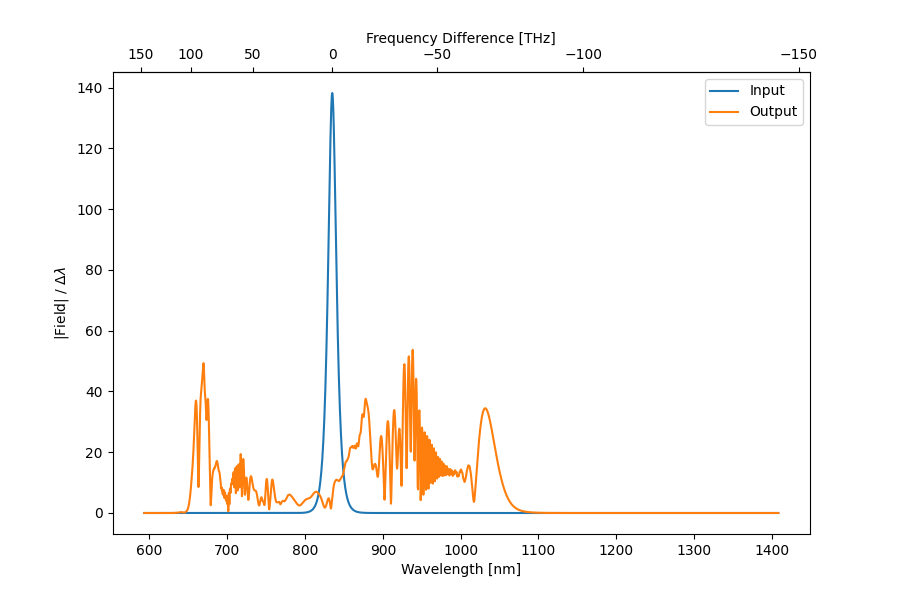

In [9]:
fig = plt.figure()

ddlambda = 1 / np.diff(np.concatenate([fftshift(wavelengthP), [2*wavelengthP[-1] - wavelengthP[-2]]]))

plt.plot(fftshift(wavelengthP), fftshift(np.abs(fiber.signalFreq[0])) * ddlambda, label="Input")
plt.plot(fftshift(wavelengthP), fftshift(np.abs(fiber.signalFreq[-50])) * ddlambda,
         label="Output")

plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("|Field| / $\Delta \lambda$")

wavelengthP = 2 * np.pi * c / (angFreq + pumpFreq) # nm

fwd, bck = lambda x: 1e-3 * c / (x + pumpFreq / (2 * np.pi)),\
           lambda x: 1e-3 * c / x - pumpFreq / (2 * np.pi)

ax = plt.gca()
secax = ax.secondary_xaxis("top", functions=(bck, fwd))
secax.set_xlabel("Frequency Difference [THz]");

<IPython.core.display.Javascript object>


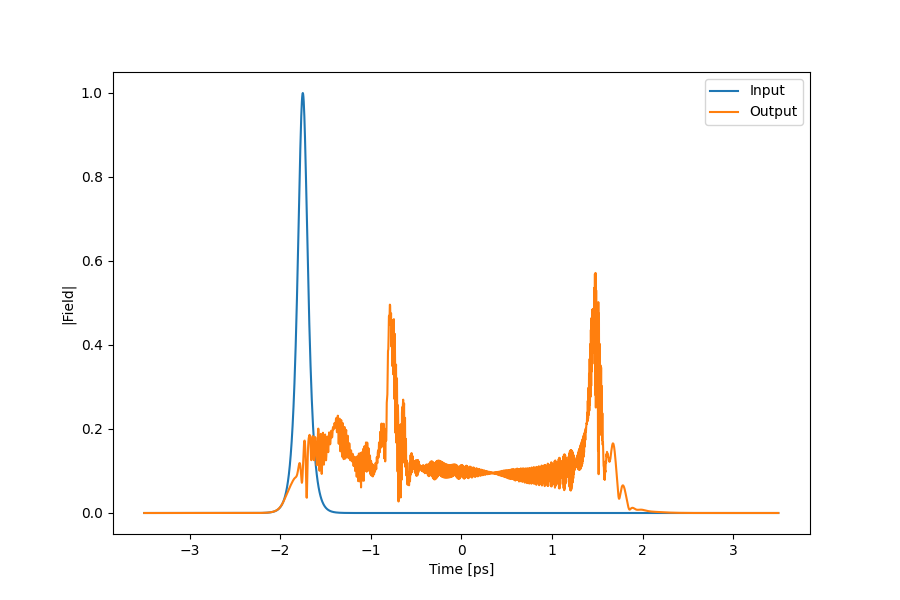

In [10]:
fig = plt.figure()
plt.plot(fftshift(time), fftshift(np.abs(fiber.signalTime[0])), label="Input")
plt.plot(fftshift(time), fftshift(np.abs(fiber.signalTime[-1])), label="Output")
plt.legend()
plt.xlabel("Time [ps]")
plt.ylabel("|Field|");

Built-in Raman gain and material response function

<IPython.core.display.Javascript object>


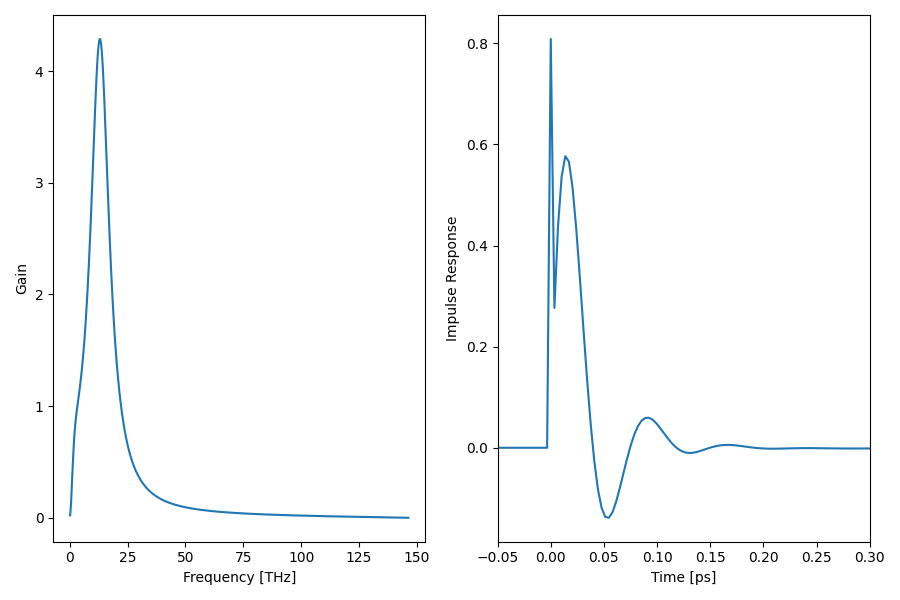

In [11]:
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.plot(angFreq[nt//2:] / (2 * np.pi), np.imag(fiber.ramanResponse)[nt//2:])
plt.xlabel("Frequency [THz]")
plt.ylabel("Gain")

plt.subplot(1, 2, 2)
plt.plot(fftshift(time), fftshift(np.real(ifft(fiber.ramanResponse))))
plt.xlim(-0.05, 0.3)
plt.xlabel("Time [ps]")
plt.ylabel("Impulse Response")
plt.tight_layout();

The standard GNLSE is known to not conserve energy

<IPython.core.display.Javascript object>


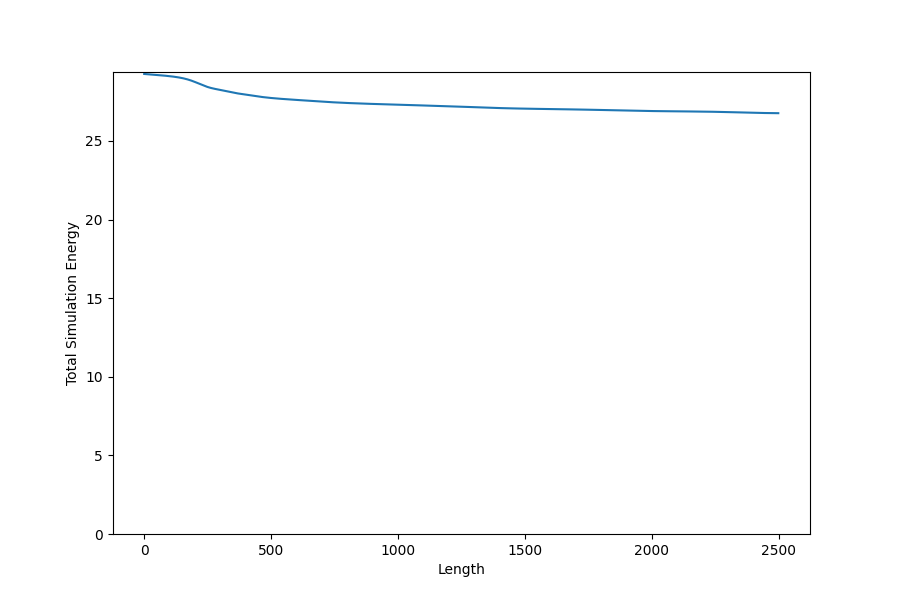

In [12]:
fig = plt.figure()
plt.plot(np.sum(np.abs(fiber.signalTime)**2, axis=1))
plt.ylim(0)
plt.xlabel("Length")
plt.ylabel("Total Simulation Energy");